In [1]:
import os
import sys
import torch
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
sys.path.append(r"C:\Users\jashw\Desktop\Video Surveillance")
from datasets.custom_dataset import get_data_loader
from models.TimeSformer.timesformer.models.vit import TimeSformer  # Import TimeSformer class

In [2]:
# ----- CONFIGURATION -----
MODEL_PATH = r"C:\Users\jashw\Desktop\Video Surveillance\data\trained_models\timesformer_finetuned.pth"  # Path to your trained model
VIDEO_PATH = r"C:\Users\jashw\Desktop\Video Surveillance\data\val\Explosion\Explosion_Explosion005_x264_clip_05.avi"  # Path to your test video
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 1
TRAIN_DIR = r"C:\Users\jashw\Desktop\Video Surveillance\data\train"
VAL_DIR = r"C:\Users\jashw\Desktop\Video Surveillance\data\val"

In [3]:
train_loader = get_data_loader(TRAIN_DIR, batch_size=BATCH_SIZE, clip_len=96, shuffle=True)
val_loader = get_data_loader(VAL_DIR, batch_size=BATCH_SIZE, clip_len=96, shuffle=False)

In [4]:
def load_model(model_path,DEVICE):
    print(f"Loading fine-tuned model from: {model_path}")

    # Create the TimeSformer model instance without pretrained_model
    model = TimeSformer(img_size=224, num_classes=8, num_frames=96,
                        attention_type='divided_space_time', pretrained_model=None) #pretrained_model=None

    # Load the state_dict from your fine-tuned model
    checkpoint = torch.load(model_path, map_location="cpu")
    model.load_state_dict(checkpoint, strict=True) #strict true
    model.to(DEVICE)

    print("Model loaded successfully!")
    return model

In [5]:

def validate_model(model,test_loader,device,class_names,batch_size,description):
        # Evaluate the model
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    print("Validating The Model....")
    with torch.no_grad(): # Disable gradient calculations during testing
        for inputs, labels in tqdm(test_loader, desc= description):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct_predictions / total_samples
    print(f'Test Accuracy: {accuracy:.4f}')

    # You can also calculate other metrics like precision, recall, F1-score
    from sklearn.metrics import classification_report
    print("\nClassification Report:")
    Classification_report = classification_report(all_labels, all_preds, target_names= class_names)
    print(Classification_report)
    return accuracy, Classification_report

In [6]:
class_names = os.listdir(VAL_DIR)
writer = SummaryWriter('runs/my_experiment')


models_dir = r"C:\Users\jashw\Desktop\Video Surveillance\models\data\trained_models\checkpoints"
models = os.listdir(models_dir)
print(models)


['best_model_epoch10_acc89.20.pth', 'best_model_epoch11_acc90.34.pth', 'best_model_epoch1_acc74.15.pth', 'best_model_epoch2_acc78.69.pth', 'best_model_epoch3_acc80.40.pth', 'best_model_epoch4_acc83.24.pth', 'best_model_epoch5_acc86.08.pth', 'best_model_epoch6_acc87.50.pth', 'best_model_epoch8_acc88.07.pth']


In [7]:

for model_name in models:
    full_model_path = os.path.join(models_dir, model_name)
    model = load_model(full_model_path, DEVICE="cuda")

    # Validate on Training Data
    train_accuracy, train_classification_report = validate_model(
        model, train_loader, DEVICE, class_names, BATCH_SIZE,
        description=f"Validating on Training Data for model {model_name}"
    )

    # Validate on Validation Data
    val_accuracy, val_classification_report = validate_model(
        model, val_loader, DEVICE, class_names, BATCH_SIZE,
        description=f"Validating on Validation Data for model {model_name}"
    )

    # Create a single string with all the details
    model_details = f"""
    Model Name: {model_name}

    Training Data:
    Accuracy: {train_accuracy:.4f}
    Classification Report:
    {train_classification_report}

    Validation Data:
    Accuracy: {val_accuracy:.4f}
    Classification Report:
    {val_classification_report}
    """

    # Log the combined details as a single text entry
    writer.add_text(f"Model Details: {model_name}", text_string=model_details)

writer.close()

Loading fine-tuned model from: C:\Users\jashw\Desktop\Video Surveillance\models\data\trained_models\checkpoints\best_model_epoch10_acc89.20.pth
Model loaded successfully!
Validating The Model....


Validating on Training Data for model best_model_epoch10_acc89.20.pth: 100%|██████████| 1600/1600 [58:51<00:00,  2.21s/it]


Test Accuracy: 0.9694

Classification Report:
                       precision    recall  f1-score   support

                Abuse       0.99      0.99      0.99       200
            Explosion       0.98      0.98      0.98       200
             Fighting       0.98      0.94      0.96       200
        RoadAccidents       0.95      0.97      0.96       200
              Robbery       0.97      0.98      0.98       200
             Shooting       0.95      0.95      0.95       200
            Vandalism       0.97      0.94      0.95       200
z_Normal_Videos_event       0.98      0.99      0.99       200

             accuracy                           0.97      1600
            macro avg       0.97      0.97      0.97      1600
         weighted avg       0.97      0.97      0.97      1600

Validating The Model....


Validating on Validation Data for model best_model_epoch10_acc89.20.pth: 100%|██████████| 352/352 [13:01<00:00,  2.22s/it]


Test Accuracy: 0.8920

Classification Report:
                       precision    recall  f1-score   support

                Abuse       1.00      0.94      0.97        50
            Explosion       0.92      0.96      0.94        50
             Fighting       0.89      0.84      0.87        50
        RoadAccidents       0.93      0.86      0.90        50
              Robbery       0.93      0.82      0.87        50
             Shooting       0.14      1.00      0.25         2
            Vandalism       0.90      0.86      0.88        50
z_Normal_Videos_event       0.89      0.96      0.92        50

             accuracy                           0.89       352
            macro avg       0.83      0.90      0.82       352
         weighted avg       0.92      0.89      0.90       352

Loading fine-tuned model from: C:\Users\jashw\Desktop\Video Surveillance\models\data\trained_models\checkpoints\best_model_epoch11_acc90.34.pth
Model loaded successfully!
Validating The Model....

Validating on Training Data for model best_model_epoch11_acc90.34.pth: 100%|██████████| 1600/1600 [1:00:00<00:00,  2.25s/it]


Test Accuracy: 0.9706

Classification Report:
                       precision    recall  f1-score   support

                Abuse       1.00      0.98      0.99       200
            Explosion       0.99      0.98      0.99       200
             Fighting       0.98      0.95      0.97       200
        RoadAccidents       0.94      0.98      0.96       200
              Robbery       0.95      0.99      0.97       200
             Shooting       0.96      0.94      0.95       200
            Vandalism       0.96      0.94      0.95       200
z_Normal_Videos_event       0.98      0.99      0.99       200

             accuracy                           0.97      1600
            macro avg       0.97      0.97      0.97      1600
         weighted avg       0.97      0.97      0.97      1600

Validating The Model....


Validating on Validation Data for model best_model_epoch11_acc90.34.pth: 100%|██████████| 352/352 [13:22<00:00,  2.28s/it]


Test Accuracy: 0.8949

Classification Report:
                       precision    recall  f1-score   support

                Abuse       0.98      0.96      0.97        50
            Explosion       0.92      0.94      0.93        50
             Fighting       0.88      0.86      0.87        50
        RoadAccidents       0.93      0.82      0.87        50
              Robbery       0.89      0.84      0.87        50
             Shooting       0.09      0.50      0.15         2
            Vandalism       0.92      0.90      0.91        50
z_Normal_Videos_event       0.92      0.96      0.94        50

             accuracy                           0.89       352
            macro avg       0.82      0.85      0.81       352
         weighted avg       0.92      0.89      0.90       352

Loading fine-tuned model from: C:\Users\jashw\Desktop\Video Surveillance\models\data\trained_models\checkpoints\best_model_epoch1_acc74.15.pth
Model loaded successfully!
Validating The Model....


Validating on Training Data for model best_model_epoch1_acc74.15.pth: 100%|██████████| 1600/1600 [1:00:42<00:00,  2.28s/it]


Test Accuracy: 0.7612

Classification Report:
                       precision    recall  f1-score   support

                Abuse       0.85      0.81      0.83       200
            Explosion       0.90      0.89      0.90       200
             Fighting       0.79      0.75      0.77       200
        RoadAccidents       0.72      0.80      0.76       200
              Robbery       0.63      0.83      0.72       200
             Shooting       0.64      0.48      0.55       200
            Vandalism       0.72      0.70      0.71       200
z_Normal_Videos_event       0.87      0.82      0.85       200

             accuracy                           0.76      1600
            macro avg       0.76      0.76      0.76      1600
         weighted avg       0.76      0.76      0.76      1600

Validating The Model....


Validating on Validation Data for model best_model_epoch1_acc74.15.pth: 100%|██████████| 352/352 [13:24<00:00,  2.28s/it]


Test Accuracy: 0.7330

Classification Report:
                       precision    recall  f1-score   support

                Abuse       0.83      0.76      0.79        50
            Explosion       0.88      0.86      0.87        50
             Fighting       0.76      0.64      0.70        50
        RoadAccidents       0.79      0.68      0.73        50
              Robbery       0.67      0.86      0.75        50
             Shooting       0.00      0.00      0.00         2
            Vandalism       0.74      0.56      0.64        50
z_Normal_Videos_event       0.78      0.80      0.79        50

             accuracy                           0.73       352
            macro avg       0.68      0.65      0.66       352
         weighted avg       0.77      0.73      0.75       352

Loading fine-tuned model from: C:\Users\jashw\Desktop\Video Surveillance\models\data\trained_models\checkpoints\best_model_epoch2_acc78.69.pth
Model loaded successfully!
Validating The Model....


Validating on Training Data for model best_model_epoch2_acc78.69.pth: 100%|██████████| 1600/1600 [1:00:42<00:00,  2.28s/it]


Test Accuracy: 0.8256

Classification Report:
                       precision    recall  f1-score   support

                Abuse       0.89      0.88      0.88       200
            Explosion       0.88      0.94      0.91       200
             Fighting       0.87      0.80      0.83       200
        RoadAccidents       0.81      0.83      0.82       200
              Robbery       0.75      0.82      0.79       200
             Shooting       0.79      0.57      0.67       200
            Vandalism       0.76      0.81      0.79       200
z_Normal_Videos_event       0.85      0.94      0.90       200

             accuracy                           0.83      1600
            macro avg       0.83      0.83      0.82      1600
         weighted avg       0.83      0.83      0.82      1600

Validating The Model....


Validating on Validation Data for model best_model_epoch2_acc78.69.pth: 100%|██████████| 352/352 [13:22<00:00,  2.28s/it]


Test Accuracy: 0.7727

Classification Report:
                       precision    recall  f1-score   support

                Abuse       0.87      0.82      0.85        50
            Explosion       0.83      0.90      0.87        50
             Fighting       0.76      0.68      0.72        50
        RoadAccidents       0.85      0.68      0.76        50
              Robbery       0.75      0.82      0.78        50
             Shooting       0.00      0.00      0.00         2
            Vandalism       0.77      0.66      0.71        50
z_Normal_Videos_event       0.83      0.88      0.85        50

             accuracy                           0.77       352
            macro avg       0.71      0.68      0.69       352
         weighted avg       0.80      0.77      0.79       352

Loading fine-tuned model from: C:\Users\jashw\Desktop\Video Surveillance\models\data\trained_models\checkpoints\best_model_epoch3_acc80.40.pth
Model loaded successfully!
Validating The Model....


Validating on Training Data for model best_model_epoch3_acc80.40.pth: 100%|██████████| 1600/1600 [1:00:36<00:00,  2.27s/it]


Test Accuracy: 0.8669

Classification Report:
                       precision    recall  f1-score   support

                Abuse       0.91      0.92      0.92       200
            Explosion       0.95      0.93      0.94       200
             Fighting       0.90      0.86      0.88       200
        RoadAccidents       0.87      0.87      0.87       200
              Robbery       0.87      0.81      0.84       200
             Shooting       0.70      0.83      0.76       200
            Vandalism       0.86      0.78      0.82       200
z_Normal_Videos_event       0.90      0.94      0.92       200

             accuracy                           0.87      1600
            macro avg       0.87      0.87      0.87      1600
         weighted avg       0.87      0.87      0.87      1600

Validating The Model....


Validating on Validation Data for model best_model_epoch3_acc80.40.pth: 100%|██████████| 352/352 [13:18<00:00,  2.27s/it]


Test Accuracy: 0.7955

Classification Report:
                       precision    recall  f1-score   support

                Abuse       0.90      0.86      0.88        50
            Explosion       0.92      0.90      0.91        50
             Fighting       0.81      0.76      0.78        50
        RoadAccidents       0.87      0.68      0.76        50
              Robbery       0.80      0.78      0.79        50
             Shooting       0.04      0.50      0.07         2
            Vandalism       0.85      0.70      0.77        50
z_Normal_Videos_event       0.88      0.90      0.89        50

             accuracy                           0.80       352
            macro avg       0.76      0.76      0.73       352
         weighted avg       0.86      0.80      0.82       352

Loading fine-tuned model from: C:\Users\jashw\Desktop\Video Surveillance\models\data\trained_models\checkpoints\best_model_epoch4_acc83.24.pth
Model loaded successfully!
Validating The Model....


Validating on Training Data for model best_model_epoch4_acc83.24.pth: 100%|██████████| 1600/1600 [1:00:32<00:00,  2.27s/it]


Test Accuracy: 0.9131

Classification Report:
                       precision    recall  f1-score   support

                Abuse       0.96      0.94      0.95       200
            Explosion       0.95      0.95      0.95       200
             Fighting       0.92      0.91      0.91       200
        RoadAccidents       0.89      0.94      0.91       200
              Robbery       0.87      0.92      0.89       200
             Shooting       0.85      0.84      0.84       200
            Vandalism       0.92      0.85      0.89       200
z_Normal_Videos_event       0.94      0.96      0.95       200

             accuracy                           0.91      1600
            macro avg       0.91      0.91      0.91      1600
         weighted avg       0.91      0.91      0.91      1600

Validating The Model....


Validating on Validation Data for model best_model_epoch4_acc83.24.pth: 100%|██████████| 352/352 [13:02<00:00,  2.22s/it]


Test Accuracy: 0.8239

Classification Report:
                       precision    recall  f1-score   support

                Abuse       0.90      0.86      0.88        50
            Explosion       0.87      0.92      0.89        50
             Fighting       0.79      0.82      0.80        50
        RoadAccidents       0.86      0.72      0.78        50
              Robbery       0.85      0.82      0.84        50
             Shooting       0.07      0.50      0.12         2
            Vandalism       0.84      0.74      0.79        50
z_Normal_Videos_event       0.90      0.90      0.90        50

             accuracy                           0.82       352
            macro avg       0.76      0.79      0.75       352
         weighted avg       0.85      0.82      0.84       352

Loading fine-tuned model from: C:\Users\jashw\Desktop\Video Surveillance\models\data\trained_models\checkpoints\best_model_epoch5_acc86.08.pth
Model loaded successfully!
Validating The Model....


Validating on Training Data for model best_model_epoch5_acc86.08.pth: 100%|██████████| 1600/1600 [1:00:18<00:00,  2.26s/it]


Test Accuracy: 0.9256

Classification Report:
                       precision    recall  f1-score   support

                Abuse       0.98      0.97      0.97       200
            Explosion       0.96      0.97      0.97       200
             Fighting       0.94      0.92      0.93       200
        RoadAccidents       0.92      0.93      0.92       200
              Robbery       0.86      0.94      0.90       200
             Shooting       0.93      0.81      0.86       200
            Vandalism       0.90      0.90      0.90       200
z_Normal_Videos_event       0.94      0.96      0.95       200

             accuracy                           0.93      1600
            macro avg       0.93      0.93      0.93      1600
         weighted avg       0.93      0.93      0.93      1600

Validating The Model....


Validating on Validation Data for model best_model_epoch5_acc86.08.pth: 100%|██████████| 352/352 [12:36<00:00,  2.15s/it]


Test Accuracy: 0.8523

Classification Report:
                       precision    recall  f1-score   support

                Abuse       0.96      0.86      0.91        50
            Explosion       0.90      0.94      0.92        50
             Fighting       0.82      0.84      0.83        50
        RoadAccidents       0.91      0.80      0.85        50
              Robbery       0.82      0.80      0.81        50
             Shooting       0.08      0.50      0.13         2
            Vandalism       0.85      0.78      0.81        50
z_Normal_Videos_event       0.92      0.96      0.94        50

             accuracy                           0.85       352
            macro avg       0.78      0.81      0.78       352
         weighted avg       0.88      0.85      0.86       352

Loading fine-tuned model from: C:\Users\jashw\Desktop\Video Surveillance\models\data\trained_models\checkpoints\best_model_epoch6_acc87.50.pth
Model loaded successfully!
Validating The Model....


Validating on Training Data for model best_model_epoch6_acc87.50.pth: 100%|██████████| 1600/1600 [1:00:16<00:00,  2.26s/it]


Test Accuracy: 0.9419

Classification Report:
                       precision    recall  f1-score   support

                Abuse       0.97      0.97      0.97       200
            Explosion       0.98      0.96      0.97       200
             Fighting       0.95      0.91      0.93       200
        RoadAccidents       0.89      0.96      0.92       200
              Robbery       0.89      0.97      0.93       200
             Shooting       0.92      0.89      0.91       200
            Vandalism       0.98      0.89      0.93       200
z_Normal_Videos_event       0.98      0.98      0.98       200

             accuracy                           0.94      1600
            macro avg       0.94      0.94      0.94      1600
         weighted avg       0.94      0.94      0.94      1600

Validating The Model....


Validating on Validation Data for model best_model_epoch6_acc87.50.pth: 100%|██████████| 352/352 [12:42<00:00,  2.17s/it]


Test Accuracy: 0.8523

Classification Report:
                       precision    recall  f1-score   support

                Abuse       0.94      0.90      0.92        50
            Explosion       0.94      0.92      0.93        50
             Fighting       0.80      0.80      0.80        50
        RoadAccidents       0.85      0.80      0.82        50
              Robbery       0.82      0.84      0.83        50
             Shooting       0.08      0.50      0.13         2
            Vandalism       0.91      0.80      0.85        50
z_Normal_Videos_event       0.92      0.92      0.92        50

             accuracy                           0.85       352
            macro avg       0.78      0.81      0.78       352
         weighted avg       0.88      0.85      0.86       352

Loading fine-tuned model from: C:\Users\jashw\Desktop\Video Surveillance\models\data\trained_models\checkpoints\best_model_epoch8_acc88.07.pth
Model loaded successfully!
Validating The Model....


Validating on Training Data for model best_model_epoch8_acc88.07.pth: 100%|██████████| 1600/1600 [57:48<00:00,  2.17s/it]


Test Accuracy: 0.9581

Classification Report:
                       precision    recall  f1-score   support

                Abuse       0.98      0.97      0.98       200
            Explosion       0.97      0.97      0.97       200
             Fighting       0.98      0.93      0.95       200
        RoadAccidents       0.95      0.96      0.96       200
              Robbery       0.94      0.97      0.96       200
             Shooting       0.91      0.94      0.93       200
            Vandalism       0.96      0.93      0.94       200
z_Normal_Videos_event       0.96      0.98      0.97       200

             accuracy                           0.96      1600
            macro avg       0.96      0.96      0.96      1600
         weighted avg       0.96      0.96      0.96      1600

Validating The Model....


Validating on Validation Data for model best_model_epoch8_acc88.07.pth: 100%|██████████| 352/352 [12:29<00:00,  2.13s/it]

Test Accuracy: 0.8693

Classification Report:
                       precision    recall  f1-score   support

                Abuse       1.00      0.92      0.96        50
            Explosion       0.91      0.96      0.93        50
             Fighting       0.91      0.80      0.85        50
        RoadAccidents       0.93      0.84      0.88        50
              Robbery       0.87      0.82      0.85        50
             Shooting       0.06      0.50      0.10         2
            Vandalism       0.89      0.82      0.85        50
z_Normal_Videos_event       0.89      0.94      0.91        50

             accuracy                           0.87       352
            macro avg       0.81      0.82      0.79       352
         weighted avg       0.91      0.87      0.89       352



In [2]:
import matplotlib.pyplot as plt
import os

models_dir = r"C:\Users\jashw\Desktop\Video Surveillance\models\data\trained_models\checkpoints"
sorted(os.listdir(models_dir))

['best_model_epoch10_acc89.20.pth',
 'best_model_epoch11_acc90.34.pth',
 'best_model_epoch1_acc74.15.pth',
 'best_model_epoch2_acc78.69.pth',
 'best_model_epoch3_acc80.40.pth',
 'best_model_epoch4_acc83.24.pth',
 'best_model_epoch5_acc86.08.pth',
 'best_model_epoch6_acc87.50.pth',
 'best_model_epoch8_acc88.07.pth']

In [ ]:
acc_dict = {
    "best_model_epoch1_acc74.15.pth" :
        {
            "Training Data" : 0.7612,
            "Validation Data" : 0.7330
        },
    "best_model_epoch2_acc78.69.pth" :
        {
            "Training Data" : 0.8256,
            "Validation Data" : 0.7727
        },
    "best_model_epoch3_acc80.40.pth" :
        {
            "Training Data" : 0.8669,
            "Validation Data" : 0.7955
        },
    "best_model_epoch4_acc83.24.pth" :
        {
            "Training Data" : 0.9131,
            "Validation Data" : 0.8239
        },
    "best_model_epoch5_acc86.08.pth" :
        {
            "Training Data" : 0.9256,
            "Validation Data" : 0.8523
        },
    "best_model_epoch6_acc87.50.pth" :
        {
            "Training Data" : 0.9419,
            "Validation Data" : 0.8523
        },
    "best_model_epoch8_acc88.07.pth" :
        {
            "Training Data" : 0.9581,
            "Validation Data" : 0.8693
        },
    "best_model_epoch10_acc89.20.pth" :
        {
            "Training Data" : 0.9694,
            "Validation Data" : 0.8920
        },
    "best_model_epoch11_acc90.34.pth" :
        {
            "Training Data" : 0.9706,
            "Validation Data" : 0.8949
        }
}

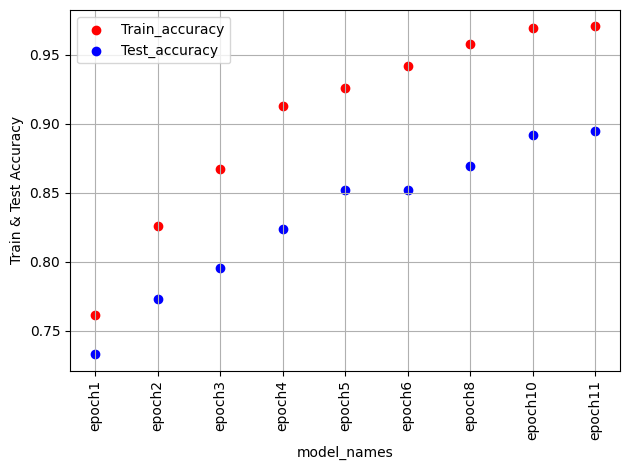

In [54]:
import re

model_names = [key for key, value in acc_dict.items()]
temp = []
for model_name in model_names:
    match = re.search(r"epoch\d+",model_name)
    temp.append(match.group(0))

model_names = temp.copy()

Train_accuracy = [value["Training Data"] for _ , value in acc_dict.items()]
# print(Train_accuracy)
Test_accuracy = [value["Validation Data"] for _ , value in acc_dict.items()]
# print(Test_accuracy)

# plt.figure(figsize=(8,8))
plt.scatter(model_names , Train_accuracy ,c='r',label= "Train_accuracy")
plt.scatter(model_names , Test_accuracy ,c='b',label =  "Test_accuracy")
plt.legend()
plt.grid(True)
plt.xticks(rotation = 90)
plt.xlabel("model_names")
plt.ylabel("Train & Test Accuracy")
plt.tight_layout()
plt.savefig(r"C:\Users\jashw\Desktop\Video Surveillance\scripts\plots\Train & Val Accuracy plot.png",dpi = 600)
plt.show()

In [3]:
import random

lst = ["NH7", "New classic"]
random.choice(lst)

'New classic'